In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

t20_data = pd.read_csv('D:/kaggle/T20_matches_ball_by_ball_data.csv', parse_dates=["date"], low_memory=False)

In [2]:
t20_data.isnull().sum()

Match_Id                0
team                    0
team2                   0
season                  0
date                    0
series              68936
match_number        23099
venue                   0
city                26728
toss_winner             0
toss_decision           0
player_of_match      6635
umpire                  0
reserve_umpire       5991
tv_umpire           21976
match_referee           0
winner               2854
winner_wickets      72039
winner_runs         63727
neutralvenue        72972
method             128855
outcome            130058
bowl_out           132415
competition         78320
eliminator         131352
Innings                 0
Overs                   0
Batting_Team            0
Striker                 0
Non_Striker             0
Bowler                  0
Run_Scored              0
Extras                  0
Dismissal          125605
Dismissed          125605
dtype: int64

In [3]:
# Acculmulate each batsman score in each match
runs_scored = t20_data.groupby(["Match_Id", "Batting_Team", "Striker"], as_index=False)["Run_Scored"].sum() 
# Count all the balls each batsman faced in a match
balls_faced = t20_data.groupby(["Match_Id", "Batting_Team", "Striker"], as_index=False)["Run_Scored"].count()
balls_faced.columns = ["Match_Id", "Batting_Team", "Striker", "Balls_Faced"]
# Merging the two dataframes to make a complete batting scoreboard
batting_scoreboard = pd.merge(runs_scored, balls_faced, 
                              on=["Match_Id", "Batting_Team", "Striker"], how="left") 

In [4]:
t20_dismissal = t20_data[["Match_Id", "Batting_Team", "Striker", "Dismissal"]]
t20_dismissal["concat_key"] = t20_dismissal["Match_Id"].map(str) + ":" + t20_dismissal["Striker"]
t20_dismissal = t20_dismissal.drop_duplicates(subset=["concat_key"], keep="last")
t20_dismissal = t20_dismissal.drop(labels="concat_key", axis = 1)
t20_dismissal = t20_dismissal.sort_values(["Match_Id", "Batting_Team"])
t20_dismissal.Dismissal.fillna("not out", inplace=True)

c:\users\azfar\python\python35\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
batting_scoreboard = pd.merge(batting_scoreboard, t20_dismissal, 
                              on=["Match_Id", "Batting_Team", "Striker"], how="left")
batting_scoreboard.head()

,Match_Id,Batting_Team,Striker,Run_Scored,Balls_Faced,Dismissal
0,211028,Australia,A Symonds,0,2,caught
1,211028,Australia,AC Gilchrist,15,14,caught
2,211028,Australia,B Lee,15,20,caught
3,211028,Australia,DR Martyn,4,4,caught
4,211028,Australia,GD McGrath,5,12,bowled


In [6]:
# Get a unique list of batsman from the scoreboard dataframe
batsman_statistics = pd.DataFrame({"Batsman": batting_scoreboard.Striker.unique()})

In [7]:
# Compute "Innings" information for each batsman from the scoreboard dataframe
Innings = pd.DataFrame(batting_scoreboard.Striker.value_counts())
Innings.reset_index(inplace=True)
Innings.columns = ["Batsman", "Innings"]

In [8]:
# Compute "Not outs" information for each batsman from the scoreboard dataframe
Not_out = batting_scoreboard.Dismissal == "not out"
batting_scoreboard["Not_out"] = Not_out.map({True: 1, False: 0})
Not_out = pd.DataFrame(batting_scoreboard.groupby(["Striker"])["Not_out"].sum())
Not_out.reset_index(inplace=True)
Not_out.columns = ["Batsman", "Not_out"]

In [9]:
# Compute "Balls" information for each batsman from the scoreboard dataframe
Balls = pd.DataFrame(batting_scoreboard.groupby(["Striker"])["Balls_Faced"].sum())
Balls.reset_index(inplace=True)
Balls.columns = ["Batsman", "Balls_Faced"]

In [10]:
# Compute "Runs" information for each batsman from the scoreboard dataframe
Run_Scored = pd.DataFrame(batting_scoreboard.groupby(["Striker"])["Run_Scored"].sum())
Run_Scored.reset_index(inplace=True)
Run_Scored.columns = ["Batsman", "Run_Scored"]

In [11]:
# Compute "Highest score" information for each batsman from the scoreboard dataframe
Highest_Score = pd.DataFrame(batting_scoreboard.groupby(["Striker"])["Run_Scored"].max())
Highest_Score.reset_index(inplace=True)
Highest_Score.columns = ["Batsman", "Highest_Score"]

In [12]:
# Compute "Centuries " information for each batsman from the scoreboard dataframe
Centuries = pd.DataFrame(batting_scoreboard.loc[batting_scoreboard.Run_Scored >= 100,].groupby(["Striker"])["Run_Scored"].count())
Centuries.reset_index(inplace=True)
Centuries.columns = ["Batsman", "Centuries"]

In [13]:
# Compute "Half Centuries " information for each batsman from the scoreboard dataframe
Half_Centuries = pd.DataFrame(batting_scoreboard.loc[(batting_scoreboard.Run_Scored >= 50) & 
                                                     (batting_scoreboard.Run_Scored < 100),].groupby(["Striker"])["Run_Scored"].count())
Half_Centuries.reset_index(inplace=True)
Half_Centuries.columns = ["Batsman", "Half_Centuries"]

In [14]:
# Merge all the metric to the batsman statitics dataframe
batsman_statistics = pd.merge(batsman_statistics, Innings, on=["Batsman"], how="left")
batsman_statistics = pd.merge(batsman_statistics, Not_out, on=["Batsman"], how="left")
batsman_statistics = pd.merge(batsman_statistics, Balls, on=["Batsman"], how="left")
batsman_statistics = pd.merge(batsman_statistics, Run_Scored, on=["Batsman"], how="left")
batsman_statistics = pd.merge(batsman_statistics, Highest_Score, on=["Batsman"], how="left")

batsman_statistics = pd.merge(batsman_statistics, Centuries, on=["Batsman"], how="left")
batsman_statistics.Centuries.fillna(0, inplace=True)
batsman_statistics.Centuries = batsman_statistics.Centuries.astype("int")

batsman_statistics = pd.merge(batsman_statistics, Half_Centuries, on=["Batsman"], how="left")
batsman_statistics.Half_Centuries.fillna(0, inplace=True)
batsman_statistics.Half_Centuries = batsman_statistics.Half_Centuries.astype("int")

In [15]:
# Compute "Batting average" for each batsman from the scoreboard dataframe
batsman_statistics["Batting_Average"] = batsman_statistics.Run_Scored / (batsman_statistics.Innings - batsman_statistics.Not_out)
batsman_statistics.loc[batsman_statistics["Batting_Average"] == np.inf, "Batting_Average"] = 0
batsman_statistics.loc[batsman_statistics["Batting_Average"].isnull(), "Batting_Average"] = 0

In [16]:
# Compute "Strike rate for each batsman from the scoreboard dataframe
batsman_statistics["Strike_Rate"] = (batsman_statistics.Run_Scored * 100) / batsman_statistics.Balls_Faced
batsman_statistics = batsman_statistics.round({"Batting_Average": 2, "Strike_Rate": 2})
batsman_statistics = batsman_statistics.sort_values(['Run_Scored'], ascending=False)
batsman_statistics.head()

,Batsman,Innings,Not_out,Balls_Faced,Run_Scored,Highest_Score,Centuries,Half_Centuries,Batting_Average,Strike_Rate
21,BB McCullum,70,15,1629,2145,123,2,13,39.00,131.68
65,TM Dilshan,76,14,1553,1830,104,1,13,29.52,117.84
262,MJ Guptill,59,11,1429,1814,101,1,10,37.79,126.94
430,V Kohli,45,13,1326,1749,90,0,16,54.66,131.90
365,Mohammad Shahzad,53,4,1262,1713,118,1,12,34.96,135.74


In [17]:
# Calculating bowling statistics
# t20_data["Bowling_Team"] = t20_data[["team", "team2"]]
t20_data["Bowling_Team"] = pd.DataFrame(np.where(t20_data.Batting_Team == t20_data.team, t20_data.team2, t20_data.team))

# Balls bowled by each bowler
balls_bowled = pd.DataFrame(t20_data["Bowler"].value_counts())
balls_bowled.index.name= 'Bowler'
balls_bowled.columns = ["Total_Ball_Bowled"]
balls_bowled.head()

,Total_Ball_Bowled
Bowler,
Shahid Afridi,2132
SL Malinga,1513
Saeed Ajmal,1457
Sohail Tanvir,1264
KMDN Kulasekara,1259


In [18]:
# Calculate Runs given by each bowler
t20_data["runs_plus_extras"] = t20_data["Run_Scored"] + t20_data["Extras"]
runs_given = t20_data.groupby([ "Bowler"])["runs_plus_extras"].sum()
runs_given = pd.DataFrame(runs_given)
runs_given.reset_index()
runs_given.head()

,runs_plus_extras
Bowler,
A Bhattarai,13
A Dananjaya,99
A Flintoff,164
A Karn,31
A Khan,34


In [19]:
# Wickets taken by each bowler 
t20_data["wickets_taken"] = t20_data["Dismissal"].isnull().map({True: 0, False: 1})
wickets_taken = pd.DataFrame(t20_data.groupby(["Bowler"])["wickets_taken"].sum())
wickets_taken.reset_index()
wickets_taken.head()

,wickets_taken
Bowler,
A Bhattarai,2
A Dananjaya,7
A Flintoff,5
A Karn,1
A Khan,2


In [20]:
bowling_statistics = pd.merge(balls_bowled, runs_given, how="left", left_index=True, right_index=True)
bowling_statistics = pd.merge(bowling_statistics, wickets_taken, how="left", left_index=True, right_index=True)
bowling_statistics["Economy"] = bowling_statistics["runs_plus_extras"]/(bowling_statistics["Total_Ball_Bowled"]/6)
bowling_statistics["Average"] = bowling_statistics["runs_plus_extras"]/ bowling_statistics["wickets_taken"]
bowling_statistics["Overs"] = bowling_statistics["Total_Ball_Bowled"]/6
bowling_statistics = bowling_statistics.round({"Economy": 2, "Average": 2, "Overs": 0 })
bowling_statistics.columns = ["Total_Ball_Bowled", "Total Runs", "Total Wickets", "Economy", "Average", "Overs" ]
bowling_statistics = bowling_statistics[["Overs", "Total Runs", "Total Wickets", "Economy", "Average"]]
bowling_statistics.head()

,Overs,Total Runs,Total Wickets,Economy,Average
Bowler,,,,,
Shahid Afridi,355.0,2366,103,6.66,22.97
SL Malinga,252.0,1799,105,7.13,17.13
Saeed Ajmal,243.0,1564,94,6.44,16.64
Sohail Tanvir,211.0,1470,61,6.98,24.10
KMDN Kulasekara,210.0,1535,73,7.32,21.03


In [21]:
# Now let's calculate runs scored by each team against each other
t20_data["Total_Runs"] = t20_data["Run_Scored"] + t20_data["Extras"] # Adding runs scored + extras to get total runs col
df_runs = t20_data[["team","team2", "Batting_Team", "Total_Runs"]] # filter relevant cols
runs_Scored_by_teams = df_runs.groupby(["team", "team2", "Batting_Team"]).sum() # sum runs scored by each team 
runs_Scored_by_teams = runs_Scored_by_teams.reset_index()
runs_Scored_by_teams.head()

,team,team2,Batting_Team,Total_Runs
0,Afghanistan,Canada,Afghanistan,174
1,Afghanistan,Canada,Canada,133
2,Afghanistan,England,Afghanistan,207
3,Afghanistan,England,England,338
4,Afghanistan,Hong Kong,Afghanistan,612


In [24]:
# Similarly balls played by each team against each other
balls_played_by_teams = runs_Scored_by_teams.groupby(["team", "team2", "Batting_Team"]).count() 
balls_played_by_teams = balls_played_by_teams.reset_index()
balls_played_by_teams.columns = ["team", "team2", "Batting_Team", "Total_Balls"]
balls_played_by_teams.head()

,team,team2,Batting_Team,Total_Balls
0,Afghanistan,Canada,Afghanistan,1
1,Afghanistan,Canada,Canada,1
2,Afghanistan,England,Afghanistan,1
3,Afghanistan,England,England,1
4,Afghanistan,Hong Kong,Afghanistan,1


In [25]:
# Batting rate per over of teams against each other
team_statistics = pd.merge(runs_Scored_by_teams, balls_played_by_teams, on=["team", "team2", "Batting_Team"], how="left" )
team_statistics["RPO"] = team_statistics["Total_Runs"]/(team_statistics["Total_Balls"]/6) 
team_statistics.head()

,team,team2,Batting_Team,Total_Runs,Total_Balls,RPO
0,Afghanistan,Canada,Afghanistan,174,1,1044.0
1,Afghanistan,Canada,Canada,133,1,798.0
2,Afghanistan,England,Afghanistan,207,1,1242.0
3,Afghanistan,England,England,338,1,2028.0
4,Afghanistan,Hong Kong,Afghanistan,612,1,3672.0


In [26]:
# Now let's calculate the Net Run Rate (NRR) for each team as a whole
# Batting rate per over for each team as a whole
runs_scored_by_X_team = pd.DataFrame(t20_data.groupby(["Batting_Team"])["Total_Runs"].sum()) # Runs scored by each team in total
balls_played_by_X_team = pd.DataFrame(t20_data.groupby(["Bowling_Team"])["Bowling_Team"].count()/6) # Overs played by each team in total
balls_played_by_X_team.columns = ["Overs_Played"]
batting_rpo = pd.merge(runs_scored_by_X_team, balls_played_by_X_team,left_index=True, right_index=True ) # RATE PER OVER (RPO) in batting
batting_rpo = pd.DataFrame(batting_rpo["Total_Runs"]/batting_rpo["Overs_Played"])
batting_rpo.columns = ["Batting_RPO"]
batting_rpo.head()

,Batting_RPO
Batting_Team,
Afghanistan,7.583130
Australia,7.828717
Bangladesh,7.265816
Bermuda,5.449541
Canada,6.746060


In [27]:
# Bowling rate per over of each team as a whole
runs_scored_by_rest_of_the_teams = pd.DataFrame(t20_data.groupby(["Bowling_Team"])["Total_Runs"].sum()) # Runs scored against each team in total
balls_played_by_rest_of_the_teams = pd.DataFrame(t20_data.groupby(["Bowling_Team"])["Match_Id"].unique().str.len())*20 # To calculate bowling rate per over total ball (120) are considered instead of balls played
balls_played_by_rest_of_the_teams.columns = ['Overs_Played']
bowling_rpo = pd.merge(runs_scored_by_rest_of_the_teams, balls_played_by_rest_of_the_teams, left_index=True, right_index=True ) # RATE PER OVER (RPO) in bowling
bowling_rpo = pd.DataFrame(bowling_rpo["Total_Runs"]/(bowling_rpo["Overs_Played"]))
bowling_rpo.columns = ["Bowling_RPO"]
bowling_rpo.head()

,Bowling_RPO
Bowling_Team,
Afghanistan,7.105357
Australia,7.495161
Bangladesh,7.440984
Bermuda,5.000000
Canada,7.100000


In [28]:
# NET RUN RATE CALCULATION: RPO of (REQUIRED TEAM) - RPO of all against teams
# RPO of  (REQUIRED TEAM) = TOTAL RUNS SCORED AGAISNT ALL TEAMS / TOTAL BALLS PLAYED TO SCORE THOSE RUNS
# RPO of all against teams = TOTAL RUNS SCORED BY ALL OTHER TEAMS AGAINST REQUIRED TEAM / 20*MATCHES
net_run_rate = pd.merge(batting_rpo, bowling_rpo, left_index=True, right_index=True )
net_run_rate["Net_Run_Rate"] = net_run_rate["Batting_RPO"] - net_run_rate["Bowling_RPO"] # Calc of net run rate
net_run_rate = net_run_rate.sort_values(["Net_Run_Rate"], ascending=False) 
net_run_rate.head()

,Batting_RPO,Bowling_RPO,Net_Run_Rate
Batting_Team,,,
South Africa,7.747108,7.141237,0.605871
Hong Kong,7.027545,6.450000,0.577545
Nepal,6.012752,5.500000,0.512752
Netherlands,7.041371,6.552778,0.488593
Afghanistan,7.583130,7.105357,0.477773


In [42]:
from pandas.tools.plotting import parallel_coordinates

temp_df = t20_data[['Batting_Team', 'Striker']].drop_duplicates()
temp_df.columns = ['Batting_Team', 'Batsman']
y = pd.merge(batsman_statistics, temp_df, on=['Batsman'], how='left')
del y['Batsman']

c:\users\azfar\python\python35\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.parallel_coordinates' is deprecated, import 'pandas.plotting.parallel_coordinates' instead.
  """Entry point for launching an IPython kernel.


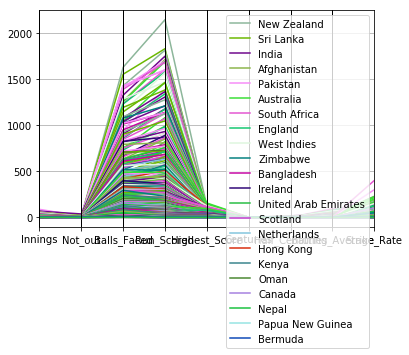

In [43]:
parallel_coordinates(y, class_column='Batting_Team')
